# Word2Vec Embeddings - Similarity Measure

In [1]:
# Librairies 
import pandas as pd
import numpy as np
from scipy import stats as scs
import matplotlib.pyplot as plt
import re
import sys
import traceback
from pprint import pprint
from multiprocessing import cpu_count
from smart_open import smart_open

from Preprocessing_Word2Vec import *

from gensim.test.utils import common_texts, get_tmpfile, datapath
from gensim.models import Word2Vec, KeyedVectors
from gensim import corpora, similarities
# from gensim.models.word2vec import Word2Vec, LineSentence

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

# from imblearn.over_sampling import RandomOverSampler

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 200)
sns.set(style="whitegrid")

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

chemin = "../Data/"

##  Example use of Gensim

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim import corpora, models, similarities

In [8]:
import gensim.downloader as api

word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data

result = word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))


result = word_vectors.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))


print(word_vectors.doesnt_match("breakfast cereal dinner lunch".split()))


similarity = word_vectors.similarity('woman', 'man')
similarity > 0.8

result = word_vectors.similar_by_word("cat")
print("{}: {:.4f}".format(*result[0]))


sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
sentence_president = 'The president greets the press in Chicago'.lower().split()

similarity = word_vectors.wmdistance(sentence_obama, sentence_president)
print("{:.4f}".format(similarity))


distance = word_vectors.distance("media", "media")
print("{:.1f}".format(distance))


sim = word_vectors.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
print("{:.4f}".format(sim))


# vector = word_vectors['computer']  # numpy vector of a word
# vector.shape


# vector = word_vectors.wv.word_vec('office', use_norm=True)
# vector.shape


queen: 0.7699
queen: 0.8965
cereal
dog: 0.8798
3.4893
0.0
0.7067


In [9]:
result = word_vectors.similar_by_word("sealant")
print(result[:10])

[('caulk', 0.6433802247047424), ('desiccant', 0.6272700428962708), ('retarder', 0.6075140833854675), ('urethane', 0.5970498323440552), ('gel', 0.5968034267425537), ('bandage', 0.5862429141998291), ('adhesive', 0.5853487253189087), ('splint', 0.5788427591323853), ('polyurethane', 0.5728068947792053), ('caulking', 0.5722010731697083)]


In [10]:
sim = word_vectors.n_similarity(['sushi'], ['japanese', 'restaurant'])
print("{:.4f}".format(sim))

0.5674


## Test French Model Word2Vec

### Import Data/Model et Preprocessing

In [2]:
# Load model
model = KeyedVectors.load_word2vec_format('D:/NLP models/word2vec/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin', binary=True)

2019-02-28 13:21:05,022 : INFO : loading projection weights from D:/NLP models/word2vec/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin
2019-02-28 13:21:11,375 : INFO : loaded (155562, 200) matrix from D:/NLP models/word2vec/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin


In [3]:
# Importation des données vendeurs
df_seller = pd.read_csv(chemin + "t3_all_fr_prices_posweekly_prod_without_price.csv", sep = ",")

#Création d'un df allégé pour le travail - on ne retient que les colonnes identifiées comme utiles pour l'analyse à ce stade
columns_to_keep = ['t3_all_fr_prices_posweekly_prod.productfamily_seller',
                   't3_all_fr_prices_posweekly_prod.prodcategory4_seller',
                   't3_all_fr_prices_posweekly_prod.prodcategory3_seller',
                   't3_all_fr_prices_posweekly_prod.prodcategory2_seller',
                   't3_all_fr_prices_posweekly_prod.prodcategory1_seller',
                   't3_all_fr_prices_posweekly_prod.productseller_name',
                   't3_all_fr_prices_posweekly_prod.id_source',
                   't3_all_fr_prices_posweekly_prod.brand_seller']

df_seller = df_seller[columns_to_keep]

#on raccourcit un peu les noms des colonnes en ôtant les préfixes redondants
shortened_names = map(lambda string: string.replace('t3_all_fr_prices_posweekly_prod.',''), columns_to_keep)
col_name_dict = dict(zip(columns_to_keep, shortened_names))
df_seller.rename(columns=col_name_dict, inplace=True)

In [4]:
# Importation des données références catégories Innoscape
df_ref = pd.read_csv(chemin + "2018.11.21_innoscape_internal_architecture.csv")
df_ref = df_ref.drop("Date", axis=1)

#On ne garde que la colonne correspondante à la famille de produit de référence finale
columns_to_keep = ['innoscape_ref_productfamily_seller']
df_ref = df_ref[columns_to_keep]
df_ref = df_ref.drop_duplicates()

In [5]:
# On enlève les lignes où il y a un NA sur toutes les colonnes ci-dessous
df_seller = df_seller.dropna(how='all', subset=['productfamily_seller',
                                                'prodcategory4_seller',
                                                'prodcategory3_seller',
                                                'prodcategory2_seller',
                                                'prodcategory1_seller',
                                                'productseller_name'])

# On remplace les NA restants par une valeur vide
df_seller = df_seller.fillna("")

In [6]:
# On enlève les lignes où il y a un NA sur toutes les colonnes ci-dessous
df_seller = df_seller.dropna(how='all', subset=['productfamily_seller',
                                                'prodcategory4_seller',
                                                'prodcategory3_seller',
                                                'prodcategory2_seller',
                                                'prodcategory1_seller',
                                                'productseller_name'])

# On remplace les NA restants par une valeur vide
df_seller = df_seller.fillna("")

# Mise en place du dictionnaire pour le regex
# 'à':'a','â':'a','ä':'a',
# 'é':'e','è':'e','ê':'e','ë':'e',
# 'ï':'i','î':'i',
# 'ô':'o','ö':'o',
# 'ù':'u','û':'u',
# 'ç':'c',
dictionary = {",":" ", "'":" ", ";":" ", ":":" ", "\?":" ", "!":" ", "\.":"", "  ":" ", 
              "\(":"", "\)":"", "\[":"", "\]":"", "-":" ", "\+":"", "/":"", "\*":"", "–":" ",
              "&":"et", "’":""}

# Importation de la liste de stop words
stop_words = ""
f = open("stop_words.txt", "r")
for x in f:
    stop_words = f.read()
stop_words = set(stop_words.split("\n"))

In [7]:
# Etape de preprocessing à partir de la fonction définie dans la bibliothèque
df_ref = preprocessing(df_ref, df_ref.columns, dictionary, stop_words)

list_new_col = ['productfamily_seller', 'prodcategory4_seller', 'prodcategory3_seller', 'prodcategory2_seller', 'prodcategory1_seller', 'productseller_name']
df_seller = preprocessing(df_seller, list_new_col, dictionary, stop_words)

### Test Similarity Product Family - REF

####  Calcul des similarités cosine dans la représentation Word2Vec

In [8]:
# detect possible missing words
missing_words = []
for i in range(len(df_seller.productfamily_seller_clean)):
    try:
        model.n_similarity(df_seller.productfamily_seller_clean.iloc[i], ['conduit'])
    except (ValueError, ZeroDivisionError, KeyError):
        missing_words.append(df_seller.productfamily_seller_clean.iloc[i])
        continue
    
flat_list = [item for sublist in missing_words for item in sublist]
missing_words_set = list(set(flat_list))

# detect missing words
missing_words = []
for i in range(len(missing_words_set)):
    try:
        model.n_similarity([missing_words_set[i]], ['conduit'])
    except (ValueError, ZeroDivisionError, KeyError):
        missing_words.append(missing_words_set[i])
        continue
        
print("Mots manquants dans le vocabulaire du model par rapport aux données vendeurs (family_product) : ", len(missing_words))

Mots manquants dans le vocabulaire du model par rapport aux données vendeurs (family_product) :  73


In [9]:
list_all_similarities = []
for i in range(len(df_seller.productfamily_seller_clean)):
    list_similarities = []
    for j in range(len(df_ref.innoscape_ref_productfamily_seller_clean)):
        try:
            list_similarities.append(model.n_similarity(df_seller.productfamily_seller_clean.iloc[i], df_ref.innoscape_ref_productfamily_seller_clean.iloc[j]))
        except (ValueError, ZeroDivisionError, KeyError):
            list_similarities.append(0)
            continue
    list_all_similarities.append(list(zip(list_similarities, list(range(103)))))

In [10]:
# On récupère le top 5 des mesures cosines avec les index
list_top5_cosine_index = []
list_top5_cosine = []
list_top5_cosine_index_value = []
list_best_cosine = []
list_best_cosine_index = []
for i in range(len(list_all_similarities)):
    list_all_similarities[i].sort(reverse=True) 
    list_top5_cosine_index_value.append(list_all_similarities[i][:5]) # get top 5
    list_top5_cosine_index.append([index[1] for index in list_top5_cosine_index_value[i]])
    list_top5_cosine.append(list(zip(*list_top5_cosine_index_value[i]))[0])
    list_best_cosine_index.append(list_top5_cosine_index[i][0])
    list_best_cosine.append(np.max(list_top5_cosine[i]))

In [11]:
# On ajoute le top 5 des réfs les plus similaires à partir de la mesure cosine
df_seller['cosine_similarity'] = list_all_similarities
df_seller['index_top5_cosine'] = list_top5_cosine_index
df_seller['top5_cosine'] = list_top5_cosine
df_seller['best_cosine'] = list_best_cosine
df_seller['index_best_cosine'] = list_best_cosine_index

In [12]:
# Jointure avec les références innoscape à partir des index
df_seller['ref_product_family'] = df_seller.index_top5_cosine.apply(lambda x: df_ref.innoscape_ref_productfamily_seller.iloc[x].values.tolist())
df_seller['ref_product_family_best'] = df_seller.index_best_cosine.apply(lambda x: df_ref.innoscape_ref_productfamily_seller.iloc[x])

In [13]:
# On récupère que les colonnes nécessaires pour la comparaison de similarité
df_similarities = df_seller.loc[:, ['productfamily_seller', 'productseller_name', 'ref_product_family', 'top5_cosine', 'ref_product_family_best', 'best_cosine']]

In [14]:
df_similarities.head(20)

productfamily_seller  \
0                      Colles à carrelage   
1                                           
2                                           
3                                  Mastic   
4                                   Cires   
5                                           
6                       Perceuse-visseuse   
7                   Produits d'étanchéité   
8                               Arroseurs   
9                                           
10                                          
11                  Pompes pour fontaines   
12                   Sécateurs et Ciseaux   
13    Accessoires pour outillage sans fil   
14  Pièces et accessoires pour chaudières   
15                                          
16     Filtres pour aspirateurs portatifs   
17                      Meuleuses d'angle   
18                                          
19                               Conduits   

                                                                                           productseller_name  \
0    SikaCeram Xtra - Colle à carrelage intérieur et extérieur pour carreaux 60x60 max (C2-ET) - 25kg - blanc   
1                                                           Ariston 3200362 scaldabagno elettrico PRO 100 H/3   
2                    AEG Panier À Couverts Lave-vaisselle Cage & Handle (6 Compartiments, handle & Couvercle)   
3                                                                       Colle-mastic pour joints d'étanchéité   
4                                   Sikagard Protection Sol MAT - Imperméabilisant pour sol avec un effet MAT   
5   Sikagard Protection Toiture inclinée - Protection contre fuites et infiltrations d'eau - 4L - terre cuite   
6                Perceuse-visseuse RYOBI 18V OnePlus - 1 batterie Lithium 1.3Ah - chargeur - sac - RCD18-L13S   
7      Sika Multiseal - Bande d'étanchéité autocollante résistante à la déchirure - 300mm x 10m - Terre cuite   
8                                                                     Black and Decker 34345 Arroseur Impulse   
9                                      Ryobi-RXB01 Cortasetos-Écartement des dents Lame longueur 15 mm-450 mm   
10                          Ryobi-OES1813 dispositif de démarrage/e-Start Chargeur batterie 18 V/1,3 Ah Lítio   
11                                                 Nortene 08092 Pompe Fontaine 230V 800L/H + Câble 10 m Noir   
12             Black and Decker  – Sécateur Longueur : 59 cm/Diamètre de Coupe : 45 mm [ébrancheur à Enclume]   
13                                                               Ryobi 5133002020 WS721S Massicot à carrelage   
14                                                                      Sécurité gaz (pochette) Réf. 60081163   
15                                       AEG HK 604200 – Plan de cuisson à induction IB Finition Noir – 60 cm   
16        AEG AFS1W Allergy Plus Filtre lavable pour AEG et Philips s-bag Compatible UltraOne et UltraSilence   
17                                                         AEG BEWS18-125LI Meuleuse Électrique sans fil 18 V   
18                                                   Mastic butyle d’étanchéité démontable - SikaLastomer 710   
19                                                ARISTON thermo 3208066 nuos Kit manchon diamètre 150, blanc   

                                                                                                                                                                                         ref_product_family  \
0                                    [Mastic colle Etanchéité , Outillage du carreleur, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Sol PVC en rouleau]   
1                                                 [Multiprise et parafoudre, Ampoules et leds, Accessoires pour nettoyeur haute pression, Visserie-clouterie, Dalles et lames bois pour terrasse et jardin]   
2                                                 [Multiprise et parafoudre, Amp

#### Analyse de la distribution des catégories potentielles

In [15]:
# On récupère les données que pour une mesure cosine supérieure à 0.5:
df_similarities_seuil = df_similarities[df_similarities["best_cosine"]>0.5]
print("nombre de lignes couverts par le seuil 0.5 : ", df_similarities_seuil.shape[0])
print("nombre de lignes au total : ", df_seller.shape[0])
print("nombre de catégories couverts par un seuil 0.5 : ", len(df_similarities_seuil.ref_product_family_best.unique()))
print("nombre de catégories couverts sans seuil : ", len(df_seller.ref_product_family_best.unique()))
print("nombre de catégories au total : ", df_ref.shape[0])

nombre de lignes couverts par le seuil 0.5 :  26474
nombre de lignes au total :  30849
nombre de catégories couverts par un seuil 0.5 :  88
nombre de catégories couverts sans seuil :  89
nombre de catégories au total :  105


On remarque que la plupart des familles de produits dans la référence innoscape est représentée au moins par un article avec la représentation Word2Vec. Voyons maintenant comment les produits sont distribués dans ces catégories (on considère seulement les données où on a une mesure de similarité >0.5) :

In [16]:
df_similarities_seuil

productfamily_seller  \
0                         Colles à carrelage   
3                                     Mastic   
4                                      Cires   
6                          Perceuse-visseuse   
7                      Produits d'étanchéité   
8                                  Arroseurs   
11                     Pompes pour fontaines   
12                      Sécateurs et Ciseaux   
13       Accessoires pour outillage sans fil   
14     Pièces et accessoires pour chaudières   
16        Filtres pour aspirateurs portatifs   
19                                  Conduits   
20                                  Conduits   
21                           Mastic au latex   
22                        Pièces et raccords   
23                      Casques et écouteurs   
24                      Bordures pour jardin   
25                       Marteau perforateur   
26                             Tronçonneuses   
27                           Stickers muraux   
28                        Colles à carrelage   
31                           Mastic au latex   
32                         Sacs porte-outils   
33                         Packs de batterie   
34                Lampes de poche (standard)   
35                                  Conduits   
36                          Ciseaux de maçon   
37                           Mastic au latex   
38                              Taille-haies   
41                     Produits d'étanchéité   
...                                      ...   
30817               Adjuvant béton & mortier   
30818               Adjuvant béton & mortier   
30819           Traitement joints & fissures   
30820        Etanchéité & Imperméabilisation   
30821        Etanchéité & Imperméabilisation   
30822               Adjuvant béton & mortier   
30823           Traitement joints & fissures   
30824               Adjuvant béton & mortier   
30826               Adjuvant béton & mortier   
30827               Adjuvant béton & mortier   
30828        Etanchéité & Imperméabilisation   
30829        Etanchéité & Imperméabilisation   
30830               Adjuvant béton & mortier   
30831        Etanchéité & Imperméabilisation   
30832           Traitement joints & fissures   
30833        Etanchéité & Imperméabilisation   
30834        Etanchéité & Imperméabilisation   
30835        Etanchéité & Imperméabilisation   
30836           Traitement joints & fissures   
30837        Etanchéité & Imperméabilisation   
30838        Etanchéité & Imperméabilisation   
30839           Traitement joints & fissures   
30840        Etanchéité & Imperméabilisation   
30841               Adjuvant béton & mortier   
30842                     Accessoire de pose   
30843               Isolation mur spécifique   
30845                                 Mousse   
30846               Isolation mur spécifique   
30847                     Accessoire de pose   
30848                                 Mousse   

                                                                                                                                                                           productseller_name  \
0                                                                                    SikaCeram Xtra - Colle à carrelage intérieur et extérieur pour carreaux 60x60 max (C2-ET) - 25kg - blanc   
3                                                                                                                                                       Colle-mastic pour joints d'étanchéité   
4                                                                                                                   Sikagard Protection Sol MAT - Imperméabilisant pour sol avec un effet MAT   
6                                                                                                Perceuse-visseuse RYOBI 18V OnePlus - 1 batterie Lithium 1.3Ah - chargeur - sac - RCD18-L13S   
7                                                                                 

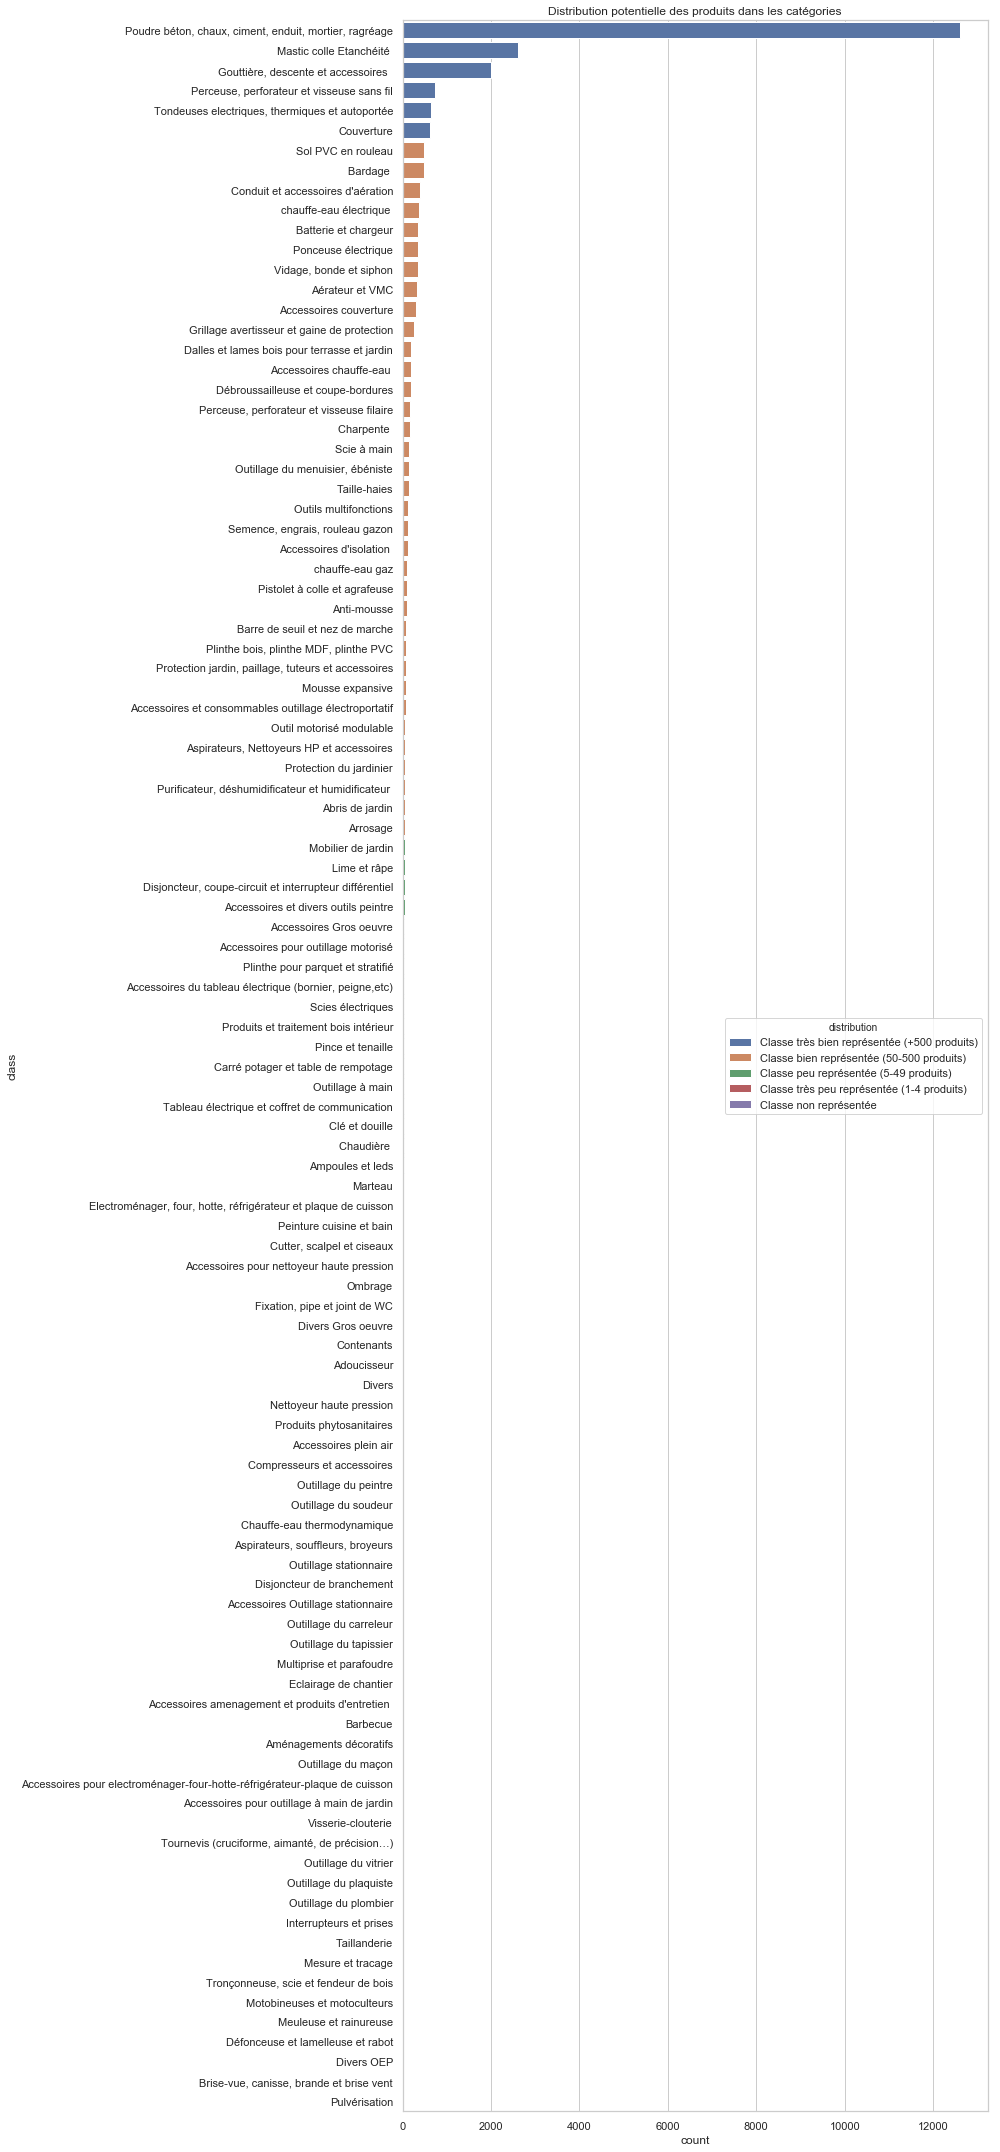

In [17]:
# Calcul de la fréquence des classes
predicted_classes = df_similarities_seuil['ref_product_family_best'].value_counts().index.tolist()
predicted_classes_count = df_similarities_seuil['ref_product_family_best'].value_counts().tolist()
classes = predicted_classes.copy()
classes_count = predicted_classes_count.copy()
for category in df_ref.innoscape_ref_productfamily_seller:
    if category not in predicted_classes:
        classes.append(category)
        classes_count.append(0)
dict_classes = {'class': classes, 'count': classes_count}
df_classes = pd.DataFrame(data=dict_classes).sort_values('count', ascending=False)

# Création d'une légende pour catégoriser les distributions des classes
distribution = []
i = 0
for index, category in enumerate(df_classes["class"], 0):
    if df_classes["count"][index]>500:
        distribution.append("Classe très bien représentée (+500 produits)")
    elif df_classes["count"][index]>=50:
        distribution.append("Classe bien représentée (50-500 produits)")
    elif df_classes["count"][index]>=5:
        distribution.append("Classe peu représentée (5-49 produits)")
    elif df_classes["count"][index]>0:
        distribution.append("Classe très peu représentée (1-4 produits)")
    else :
        distribution.append("Classe non représentée")
df_classes["distribution"] = distribution

# On affiche en barplot
plt.figure(figsize=(14,30))
sns.barplot(x="count",
            y="class",
#             data=df_classes.iloc[50:,:], # on zoome
            data=df_classes,
            hue="distribution", dodge=False)
plt.title("Distribution potentielle des produits dans les catégories")
plt.tight_layout()

In [18]:
sources_pie = go.Pie(labels=df_classes["distribution"].value_counts().index, values=df_classes["distribution"].value_counts(),
                     marker=dict(line=dict(color='#FFF', width=2)), showlegend=True,
                     name='Distribution potentielle des produits dans les catégories', textinfo='label+percent')

layout = go.Layout(height = 600,
                   width = 1000,
                   autosize = False,
                   title = 'Proportion de présence potentielle des produits dans les catégories')
fig = go.Figure(data = [sources_pie], layout = layout)

py.iplot(fig, filename='basic_pie_chart')

C:\Users\Pascal\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



On s'aperçoit qu'il y a environ 25% des catégories qui sont soit non représentées ou soit très peu représentées (<5).
Ca risque de poser des problèmes pour créer un modèle de classification supervisé car il y aura beaucoup de classes sous représentées.       
On est également embêté pour une classification semi-supervisé car toutes les classes ne sont pas représentés. On pourra potentiellement opté pour un zero shot semi-supervised learning.

#### Analyse des résultats de similarité

Si on se concentre sur les catégories les plus représentées, on s'aperçoit que les trois premiers concentrent plus de 50% des données. On va s'intéresser plus en détails à ces données :

**Poudre béton, chaux, ciment, enduit, mortier, ragréage:**

In [24]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Poudre béton, chaux, ciment, enduit, mortier, ragréage'].productfamily_seller.unique()

array(['Treillis', 'Enduits', 'Ciment - Mortier & Béton', 'Ragréage',
       'Mortier', 'Plaque et bardeau', 'Tuile', 'Tuiles',
       'Poudre (béton, chaux, ciment, enduit, mortier, ragréage, ...)',
       "Accessoires d'enduit de façade",
       'Accessoires de tuile et ardoise',
       'Etanchéité des fondations, mur enterré et dalle',
       'Adjuvant pour préparation béton et mortier',
       'Colle pour carrelage, brique de verre, plaquette de parement',
       "Produit d'étanchéité pour mur et façade",
       'Pigment pour béton et chaux', 'Malaxeur', 'Colorant pour béton',
       'Chimie du béton', 'Enduit bitumineux', 'Mortier Hydrofuge',
       'Mortier de Ragréage', 'Réparation béton',
       'Mortier de Jointoiement', 'Mortier de Réparation',
       'Mortier de Scellement', 'Scellement Chimique',
       "Enduit d'étanchéité", 'Coffrage',
       'Enduits, mortiers et revêtements de façade',
       'Agrégats (sable, gravier, gravillons)',
       'Enduits et revêtements de faç

On remarque qu'il y a beaucoup de produits qui sont mal classés malgré qu'on ait mis un seuil à 0.5. En effet le mot **tuiles** est très proche dans la représentation Word2Vec à **béton**, **chaux** et **ciment**.

In [51]:
print("Cosine tuiles/béton-chaux-ciment : ", model.n_similarity(['tuiles'], ['béton', 'chaux', 'ciment']))

Cosine tuiles/béton-chaux-ciment :  0.7489418


**Mastic colle Etanchéité:**

In [53]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Mastic colle Etanchéité '].productfamily_seller.unique()

array(['Colles à carrelage', 'Mastic', 'Cires', "Produits d'étanchéité",
       'Mastic au latex', 'Pièces et raccords', 'Colles universelles',
       'Silicones', 'Feuilles abrasives', 'Vernis', 'Colles de contact',
       'Etanchéité extérieure & Anti-mousse', 'Cartouche & Mastic',
       'Traitement étanchéité', 'Mastics', 'Cartouche mastic et joint',
       'Résine décorative', 'Etanchéité', 'Colle pour isolant',
       'Etanchéité du sol',
       'Plaque de plâtre, de doublage, et cloison alvéolaire', 'mastic',
       'Etanchéité mur', 'Colles', 'Collage', 'Joints',
       'Adhésifs, colles', 'Colles mastic', 'Colles Silicone',
       'Colles Acrylique', "Bande d'étanchéité", 'Colles polyuréthane',
       'Colles Hybride', 'Résine époxy', 'Colle et mastic colle',
       "Mastic d'étanchéité", 'Mastic de fixation',
       "Rouleau d'étanchéité", "Autre produit d'étanchéité",
       'Mastic spécial piscine',
       "Produit d'étanchéité pour fondation et cave", 'Résine',
       'Col

Les familles de produits correspondent très bien à la référence Mastic colle et étanchéité.

**Gouttière, descente et accessoires:**

In [55]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Gouttière, descente et accessoires  '].productfamily_seller.unique()

array(['Gouttière et accessoire', 'Crochet',
       'Raccord de gouttière et descente',
       'Accessoires gouttière et descente', 'Gouttière et descente',
       'Raccord pour gouttière', 'Elément de fixation pour gouttière',
       'Piquet pour grillage et accessoire', 'Vis de gouttière',
       'Accessoire pour gouttière', 'Harnais'], dtype=object)

Au global, on arrive à des familles de produit qui correspondent bien à la catégorie à l'exception de **Piquet pour grillage et accessoire** à cause du mot accessoire et **Crochet** et **Harnais** qui ne devraient pas être dans cette catégorie également.

### Test Similarity (Product Family + Description) - REF

In [14]:
df_seller['product_family_description'] = df_seller['productfamily_seller_clean'] + df_seller['productseller_name_clean']

####  Calcul des similarités cosine dans la représentation Word2Vec

In [16]:
# detect possible missing words
missing_words = []
for i in range(len(df_seller['product_family_description'])):
    try:
        model.n_similarity(df_seller['product_family_description'].iloc[i], ['conduit'])
    except (ValueError, ZeroDivisionError, KeyError):
        missing_words.append(df_seller['product_family_description'].iloc[i])
        continue
    
flat_list = [item for sublist in missing_words for item in sublist]
missing_words_set = list(set(flat_list))

# detect missing words
missing_words = []
for i in range(len(missing_words_set)):
    try:
        model.n_similarity([missing_words_set[i]], ['conduit'])
    except (ValueError, ZeroDivisionError, KeyError):
        missing_words.append(missing_words_set[i])
        continue
        
print("Mots manquants dans le vocabulaire du model par rapport aux données vendeurs (family_product) : ", len(missing_words))

Mots manquants dans le vocabulaire du model par rapport aux données vendeurs (family_product) :  3793


In [23]:
missing_words

['xcm',
 'adheflex',
 'rags',
 'rustol',
 'greca',
 'cpsmn',
 'prust',
 '"td"',
 'bicomposant',
 'ragrenov',
 'hsr',
 'plastergrid',
 'linen',
 'lant',
 'étanchétité',
 'htkot',
 'rapidclean',
 'tapefix',
 'mixem',
 'jackoboard',
 'tfp',
 'vah',
 'hgk',
 'turbotec',
 'rdroite',
 'dcsm',
 'tegurose',
 'thermocromex',
 'cvdg',
 'bsscz',
 'bdcddetbka',
 'moulclipsfs',
 'pwgolm',
 'proliband',
 'ebhl',
 'stopfeuille',
 '"passe',
 'sarking',
 'mealine',
 'omnisol',
 'rpdbl',
 'svc',
 '"olympic"',
 'prégalvanisé',
 'butanepropane',
 'kit"',
 'champrcj',
 'norten',
 'easily',
 'internas',
 'bks',
 'dcfhp',
 'ion\x99',
 'cvdl',
 'rpx',
 'crorg',
 'mstc',
 'omnicli',
 'polyuréthan',
 'moonoxychoc',
 'lics',
 'pl…',
 'sfchenliege',
 'pcsset',
 'climapro',
 'hpvvba',
 'raksd',
 'granulo',
 'ococre',
 'kplast',
 'novos',
 'nicoll',
 'ragrepar',
 'battcharg',
 'iuse',
 'ignifugé',
 'tensionneur',
 'fwjbllm',
 'diamantés',
 'féri',
 'adherence',
 'oxytol',
 'isocele',
 'xkg',
 'jsb',
 'bouveteté',
 

In [17]:
list_all_similarities = []
for i in range(len(df_seller['product_family_description'])):
    list_similarities = []
    for j in range(len(df_ref.innoscape_ref_productfamily_seller_clean)):
        try:
            list_similarities.append(model.n_similarity(df_seller['product_family_description'].iloc[i], df_ref.innoscape_ref_productfamily_seller_clean.iloc[j]))
        except (ValueError, ZeroDivisionError, KeyError):
            list_similarities.append(0)
            continue
    list_all_similarities.append(list(zip(list_similarities, list(range(103)))))

In [18]:
# On récupère le top 5 des mesures cosines avec les index
list_top5_cosine_index = []
list_top5_cosine = []
list_top5_cosine_index_value = []
list_best_cosine = []
list_best_cosine_index = []
for i in range(len(list_all_similarities)):
    list_all_similarities[i].sort(reverse=True) 
    list_top5_cosine_index_value.append(list_all_similarities[i][:5]) # get top 5
    list_top5_cosine_index.append([index[1] for index in list_top5_cosine_index_value[i]])
    list_top5_cosine.append(list(zip(*list_top5_cosine_index_value[i]))[0])
    list_best_cosine_index.append(list_top5_cosine_index[i][0])
    list_best_cosine.append(np.max(list_top5_cosine[i]))

In [19]:
# On ajoute le top 5 des réfs les plus similaires à partir de la mesure cosine
df_seller['cosine_similarity'] = list_all_similarities
df_seller['index_top5_cosine'] = list_top5_cosine_index
df_seller['top5_cosine'] = list_top5_cosine
df_seller['best_cosine'] = list_best_cosine
df_seller['index_best_cosine'] = list_best_cosine_index

In [20]:
# Jointure avec les références innoscape à partir des index
df_seller['ref_product_family'] = df_seller.index_top5_cosine.apply(lambda x: df_ref.innoscape_ref_productfamily_seller.iloc[x].values.tolist())
df_seller['ref_product_family_best'] = df_seller.index_best_cosine.apply(lambda x: df_ref.innoscape_ref_productfamily_seller.iloc[x])

In [21]:
# On récupère que les colonnes nécessaires pour la comparaison de similarité
df_similarities = df_seller.loc[:, ['product_family_description', 'ref_product_family', 'top5_cosine', 'ref_product_family_best', 'best_cosine']]

In [22]:
df_similarities.head(20)

product_family_description  \
0                               [colles, carrelage, xtra, extérieur, colle, sikaceram, carreaux, carrelage, max, blanc, intérieur]   
1                                                                                           [scaldabagno, elettrico, pro, ariston]   
2                                                 [couverts, aeg, cage, panier, handle, lave, couvercle, vaisselle, compartiments]   
3                                                                                      [mastic, joints, mastic, étanchéité, colle]   
4                                                                 [cires, effet, sikagard, sol, protection, mat, imperméabilisant]   
5                                      [sikagard, inclinée, contre, protection, cuite, infiltrations, fuites, terre, eau, toiture]   
6                                  [visseuse, perceuse, visseuse, lithium, batterie, oneplus, sac, perceuse, ryobi, chargeur, rcd]   
7                    [étanchéité, produits, multiseal, déchirure, autocollante, bande, cuite, étanchéité, sika, résistante, terre]   
8                                                                               [arroseurs, black, arroseur, and, decker, impulse]   
9                                                                      [cortasetos, longueur, écartement, dents, lame, ryobi, rxb]   
10                                                          [batterie, démarragee, start, dispositif, ryobi, chargeur, oes, lítio]   
11                                                                      [fontaines, pompes, pompe, fontaine, câble, nortene, noir]   
12                            [ciseaux, sécateurs, ébrancheur, enclume, black, longueur, and, decker, cmdiamètre, coupe, sécateur]   
13                                                            [fil, outillage, accessoires, sans, carrelage, massicot, ryobi, wss]   
14                                                                 [pièces, chaudières, accessoires, réf, sécurité, gaz, pochette]   
15                                                                                 [aeg, induction, cuisson, noir, plan, finition]   
16  [filtres, portatifs, aspirateurs, allergy, aeg, ultrasilence, philips, compatible, bag, afsw, filtre, ultraone, lavable, plus]   
17                                                                  [meuleuses, angle, électrique, aeg, bews, fil, sans, meuleuse]   
18                                                                         [détanchéité, démontable, mastic, butyle, sikalastomer]   
19                                                                [conduits, thermo, manchon, diamètre, nuos, blanc, kit, ariston]   

                                                                                                                                                                                         ref_product_family  \
0                                                 [Multiprise et parafoudre, Ampoules et leds, Accessoires pour nettoyeur haute pression, Visserie-clouterie, Dalles et lames bois pour terrasse et jardin]   
1                                                 [Multiprise et parafoudre, Ampoules et leds, Accessoires pour nettoyeur haute pression, Visserie-clouterie, Dalles et lames bois pour terrasse et jardin]   
2   [Accessoires pour electroménager-four-hotte-réfrigérateur-plaque de cuisson, Electroménager, four, hotte, réfrigérateur et plaque de cuisson, Accessoires chauffe-eau , Vidage, bonde et siphon, Acc...   
3                             [Mastic colle Etanchéité , Sol PVC en rouleau, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Pistolet à colle et agrafeuse]   
4                                                 [Multiprise et parafoudre, Ampoules et leds, Accessoires pour nettoyeur haute pression, Visserie-clouterie, Dalles et lames bois pour terrasse et jardin]   
5                                              

#### Analyse de la distribution des catégories potentielles

In [24]:
# On récupère les données que pour une mesure cosine supérieure à 0.5:
df_similarities_seuil = df_similarities[df_similarities["best_cosine"]>0.5]
print("nombre de lignes couverts par le seuil 0.5 : ", df_similarities_seuil.shape[0])
print("nombre de lignes au total : ", df_seller.shape[0])
print("nombre de catégories couverts par un seuil 0.5 : ", len(df_similarities_seuil.ref_product_family_best.unique()))
print("nombre de catégories couverts sans seuil : ", len(df_seller.ref_product_family_best.unique()))
print("nombre de catégories au total : ", df_ref.shape[0])

nombre de lignes couverts par le seuil 0.5 :  12937
nombre de lignes au total :  30849
nombre de catégories couverts par un seuil 0.5 :  79
nombre de catégories couverts sans seuil :  80
nombre de catégories au total :  105


On remarque que la plupart des familles de produits dans la référence innoscape est représentée au moins par un article avec la représentation Word2Vec. Voyons maintenant comment les produits sont distribués dans ces catégories (on considère seulement les données où on a une mesure de similarité >0.5) :

In [25]:
df_similarities_seuil

product_family_description  \
2                                                                                                                   [couverts, aeg, cage, panier, handle, lave, couvercle, vaisselle, compartiments]   
3                                                                                                                                                        [mastic, joints, mastic, étanchéité, colle]   
14                                                                                                                                   [pièces, chaudières, accessoires, réf, sécurité, gaz, pochette]   
15                                                                                                                                                   [aeg, induction, cuisson, noir, plan, finition]   
22                                                                                                                                  [pièces, raccords, black, and, decker, raccord, serrage, triple]   
36                                                                                                                                 [ciseaux, maçon, foret, milwaukee, pic, burin, sds, plus, argent]   
47     [balais, électriques, aspirateurs, brosse, aeg, led, sans, blanc, main, électrique, aspirante, autonomie, min, power, ani, lithium, aspirateur, partie, avant, lumières, sac, supplémentaire]   
52                                                                                                                                                                 [led, one, lanterne, multicolore]   
54                                                                                                                                            [pieds, chauffe, housse, aeg, pieds, chauffante, gris]   
58                                                                                                                                                                  [onglet, aeg, scie, multicolore]   
62                                                                                                                                                  [aeg, bobines, produits, lave, boite, vaisselle]   
67                                                                                                                                                    [colle, spécial, usage, marine, mastic, multi]   
69                                                                                                                             [balais, électriques, aspirateurs, main, aspirateur, aeg, iron, gris]   
72                                                                                             [gaz, chauffe, eau, avenir, méthane, thermo, chauffe, erp, blanc, sft, plus, eau, ariston, alimentée]   
76                                                                                                                           [pistolets, arrosage, black, résistant, and, decker, embout, fonctions]   
87                                                                                                           [packs, batterie, visseuse, batterie, aeg, électroportatif, perceuse, bse, outil, nimh]   
102                                                                                                                                    [chauffants, coussins, aeg, chauffant, coussin, températures]   
107                                                                                                  [visseuse, gun, cartouche, colle, pistolet, adaptable, mastic, sika, perceuses, easy, silicone]   
109                                                                                                                                                                   [ciseaux, sécateurs, sécateur]   
115                                                                                                                                                                 [packs

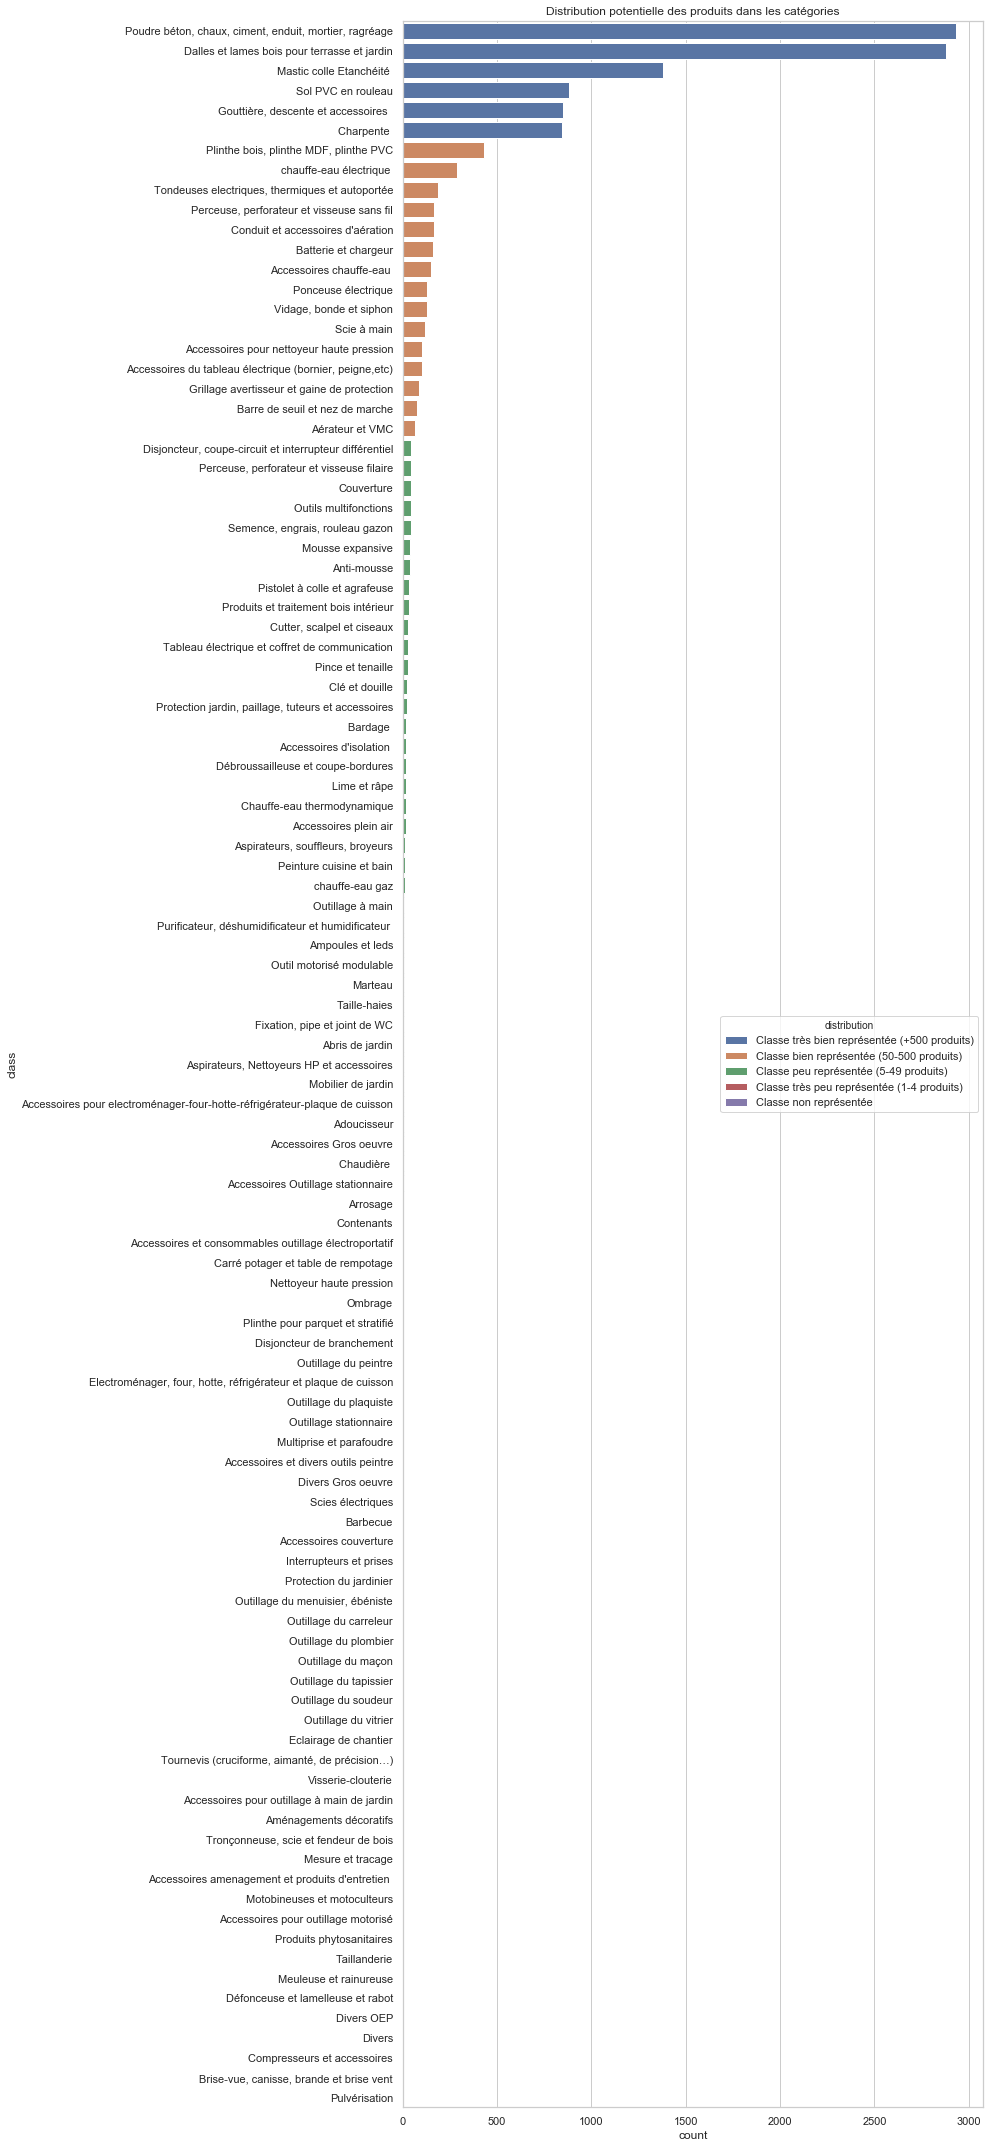

In [27]:
# Calcul de la fréquence des classes
predicted_classes = df_similarities_seuil['ref_product_family_best'].value_counts().index.tolist()
predicted_classes_count = df_similarities_seuil['ref_product_family_best'].value_counts().tolist()
classes = predicted_classes.copy()
classes_count = predicted_classes_count.copy()
for category in df_ref.innoscape_ref_productfamily_seller:
    if category not in predicted_classes:
        classes.append(category)
        classes_count.append(0)
dict_classes = {'class': classes, 'count': classes_count}
df_classes = pd.DataFrame(data=dict_classes).sort_values('count', ascending=False)

# Création d'une légende pour catégoriser les distributions des classes
distribution = []
i = 0
for index, category in enumerate(df_classes["class"], 0):
    if df_classes["count"][index]>500:
        distribution.append("Classe très bien représentée (+500 produits)")
    elif df_classes["count"][index]>=50:
        distribution.append("Classe bien représentée (50-500 produits)")
    elif df_classes["count"][index]>=5:
        distribution.append("Classe peu représentée (5-49 produits)")
    elif df_classes["count"][index]>0:
        distribution.append("Classe très peu représentée (1-4 produits)")
    else :
        distribution.append("Classe non représentée")
df_classes["distribution"] = distribution

# On affiche en barplot
plt.figure(figsize=(14,30))
sns.barplot(x="count",
            y="class",
#             data=df_classes.iloc[50:,:], # on zoome
            data=df_classes,
            hue="distribution", dodge=False)
plt.title("Distribution potentielle des produits dans les catégories")
plt.tight_layout()

In [28]:
sources_pie = go.Pie(labels=df_classes["distribution"].value_counts().index, values=df_classes["distribution"].value_counts(),
                     marker=dict(line=dict(color='#FFF', width=2)), showlegend=True,
                     name='Distribution potentielle des produits dans les catégories', textinfo='label+percent')

layout = go.Layout(height = 600,
                   width = 1000,
                   autosize = False,
                   title = 'Proportion de présence potentielle des produits dans les catégories')
fig = go.Figure(data = [sources_pie], layout = layout)

py.iplot(fig, filename='basic_pie_chart')

C:\Users\Pascal\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



On s'aperçoit qu'il y a environ 25% des catégories qui sont soit non représentées ou soit très peu représentées (<5).
Ca risque de poser des problèmes pour créer un modèle de classification supervisé car il y aura beaucoup de classes sous représentées.       
On est également embêté pour une classification semi-supervisé car toutes les classes ne sont pas représentés. On pourra potentiellement opté pour un zero shot semi-supervised learning.

#### Analyse des résultats de similarité

Si on se concentre sur les catégories les plus représentées, on s'aperçoit que les trois premiers concentrent plus de 50% des données. On va s'intéresser plus en détails à ces données :

**Poudre béton, chaux, ciment, enduit, mortier, ragréage:**

In [31]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Poudre béton, chaux, ciment, enduit, mortier, ragréage'].product_familyseller.unique()

AttributeError: 'DataFrame' object has no attribute 'product_familyseller'

On remarque qu'il y a beaucoup de produits qui sont mal classés malgré qu'on ait mis un seuil à 0.5. En effet le mot **tuiles** est très proche dans la représentation Word2Vec à **béton**, **chaux** et **ciment**.

In [51]:
print("Cosine tuiles/béton-chaux-ciment : ", model.n_similarity(['tuiles'], ['béton', 'chaux', 'ciment']))

Cosine tuiles/béton-chaux-ciment :  0.7489418


**Mastic colle Etanchéité:**

In [53]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Mastic colle Etanchéité '].productfamily_seller.unique()

array(['Colles à carrelage', 'Mastic', 'Cires', "Produits d'étanchéité",
       'Mastic au latex', 'Pièces et raccords', 'Colles universelles',
       'Silicones', 'Feuilles abrasives', 'Vernis', 'Colles de contact',
       'Etanchéité extérieure & Anti-mousse', 'Cartouche & Mastic',
       'Traitement étanchéité', 'Mastics', 'Cartouche mastic et joint',
       'Résine décorative', 'Etanchéité', 'Colle pour isolant',
       'Etanchéité du sol',
       'Plaque de plâtre, de doublage, et cloison alvéolaire', 'mastic',
       'Etanchéité mur', 'Colles', 'Collage', 'Joints',
       'Adhésifs, colles', 'Colles mastic', 'Colles Silicone',
       'Colles Acrylique', "Bande d'étanchéité", 'Colles polyuréthane',
       'Colles Hybride', 'Résine époxy', 'Colle et mastic colle',
       "Mastic d'étanchéité", 'Mastic de fixation',
       "Rouleau d'étanchéité", "Autre produit d'étanchéité",
       'Mastic spécial piscine',
       "Produit d'étanchéité pour fondation et cave", 'Résine',
       'Col

Les familles de produits correspondent très bien à la référence Mastic colle et étanchéité.

**Gouttière, descente et accessoires:**

In [55]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Gouttière, descente et accessoires  '].productfamily_seller.unique()

array(['Gouttière et accessoire', 'Crochet',
       'Raccord de gouttière et descente',
       'Accessoires gouttière et descente', 'Gouttière et descente',
       'Raccord pour gouttière', 'Elément de fixation pour gouttière',
       'Piquet pour grillage et accessoire', 'Vis de gouttière',
       'Accessoire pour gouttière', 'Harnais'], dtype=object)

Au global, on arrive à des familles de produit qui correspondent bien à la catégorie à l'exception de **Piquet pour grillage et accessoire** à cause du mot accessoire et **Crochet** et **Harnais** qui ne devraient pas être dans cette catégorie également.

### Création d'un Train set

In [ ]:
# On récup tout
df_similarities_seuil.to_csv("test_validation_embedding.csv")

In [36]:
# Dans chaque product family seller, on récupère 3 produits différents sinon le max de produits dans la famille
list_productfamily_seller_unique = df_similarities_seuil.productfamily_seller.unique()
df_train = pd.DataFrame()
# list_ref_productfamily_unique = df_similarities_seuil.ref_product_family_best.unique()
for product_family_seller in list_productfamily_seller_unique:
    df_tmp = df_similarities_seuil[df_similarities_seuil.productfamily_seller == product_family_seller]
    nb_products_in_family = df_tmp.shape[0]
    if nb_products_in_family > 4:
        nb_products_in_family = 4
    df_train = df_train.append(df_tmp.iloc[:nb_products_in_family, :])

In [39]:
df_train.head(10)

productfamily_seller  \
0     Colles à carrelage   
28    Colles à carrelage   
49    Colles à carrelage   
63    Colles à carrelage   
3                 Mastic   
57                Mastic   
85                Mastic   
108               Mastic   
4                  Cires   
186                Cires   

                                                                                                            productseller_name  \
0                     SikaCeram Xtra - Colle à carrelage intérieur et extérieur pour carreaux 60x60 max (C2-ET) - 25kg - blanc   
28                    SikaCeram Joint Fin - Mortier pour joint de carrelage prêt à gâcher intérieur / extérieur - 2kg - cendre   
49   SikaCeram Joint Dallage extérieur - Mortier joint de carrelage de largeur 5 à 50mm spécial terrasse (CG2WA) - Gris - 25kg   
63                              Colle à carrelage en pâte spéciale carreaux et plaquette de parement - SikaCeram Basic - Blanc   
3                                                                                        Colle-mastic pour joints d'étanchéité   
57          Sikacryl + - Mastic acrylique spécial fissures  pour finitions et joints en intérieur et extérieur - 300ml - chêne   
85                                                                     Purigo Sol - Durcisseur de surface anti-poussière - 20L   
108                Sikaflex PRO 11 FC - Mastic-colle tout en 1 à prise rapide et multi applications -SNJF - 600ml - gris béton   
4                                                    Sikagard Protection Sol MAT - Imperméabilisant pour sol avec un effet MAT   
186                     Sika Multiseal - Bande d'étanchéité autocollante résistante à la déchirure - 300mm x 10m - Terre cuite   

                                                                                                                                                                ref_product_family  \
0           [Mastic colle Etanchéité , Outillage du carreleur, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Sol PVC en rouleau]   
28          [Mastic colle Etanchéité , Outillage du carreleur, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Sol PVC en rouleau]   
49          [Mastic colle Etanchéité , Outillage du carreleur, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Sol PVC en rouleau]   
63          [Mastic colle Etanchéité , Outillage du carreleur, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Sol PVC en rouleau]   
3    [Mastic colle Etanchéité , Sol PVC en rouleau, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Pistolet à colle et agrafeuse]   
57   [Mastic colle Etanchéité , Sol PVC en rouleau, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Pistolet à colle et agrafeuse]   
85   [Mastic colle Etanchéité , Sol PVC en rouleau, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Pistolet à colle et agrafeuse]   
108  [Mastic colle Etanchéité , Sol PVC en rouleau, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Plinthe bois, plinthe MDF, plinthe PVC, Pistolet à colle et agrafeuse]   
4                     [Mastic colle Etanchéité , Anti-mousse, Produits et traitement bois intérieur, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Outillage du peintre]   
186                   [Mastic colle Etanchéité , Anti-mousse, Produits et traitement bois intérieur, Poudre béton, chaux, ciment, enduit, mortier, ragréage, Outillage du peintre]   

                                                    top5_cosine  \
0    (0.76378894, 0.7005101, 0.69359624, 0.68836665, 0.6848989)   
28   (0.76378894, 0.7005101, 0.69359624, 0.68836665, 0.6848989)   
49   (0.76378894, 0.7005101, 0.69359624, 0.68836665, 0.68489

In [40]:
# On récup une partie significative
df_train.to_csv("test_validation_embedding_partial.csv")

## Test English Model Word2Vec

### Import et preprocessing des données/model

In [295]:
# Load model word2vec (english model)
model = KeyedVectors.load_word2vec_format('D:/NLP models/word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [297]:
# Import des familles de produits des articles traduits en anglais
df_product_family_translated = pd.read_excel(chemin + "product_family_translated.xlsx")

# Import de la référence Innoscape (family product) traduit en angais
df_ref_product_family_translated = pd.read_excel(chemin + "ref_product_family_translated.xlsx")

In [298]:
# Cleaning
df_product_family_translated["product_family_lower"] = df_product_family_translated.product_family_translated.str.lower()
df_product_family_translated = df_product_family_translated.dropna()

In [299]:
# Mise en place du dictionnaire pour le regex
dictionary = {",":" ", "'":" ", ";":" ", ":":" ", "\?":" ", "!":" ", "\.":"", "  ":" ", 
              "\(":"", "\)":"", "\[":"", "\]":"", "-":" ", "\+":"", "/":"", "\*":"", "–":" ",
              "&":"and", "’":""}

# Importation de la liste de stop wordsen anglais
stop_words = ""
f = open("stop_words_english.txt", "r")
for x in f:
    stop_words = f.read()
stop_words = set(stop_words.split("\n"))

# Etape de preprocessing à partir de la fonction définie dans la bibliothèque
df_product_family_translated = preprocessing(df_product_family_translated, ["product_family_translated"], dictionary, stop_words)
df_ref_product_family_translated = preprocessing(df_ref_product_family_translated, ["ref_product_family_translated"], dictionary, stop_words)

In [302]:
# detect possible missing words
missing_words = []
for i in range(len(df_product_family_translated.product_family_translated_clean)):
    try:
        model.n_similarity(df_product_family_translated.product_family_translated_clean.iloc[i], ['conduit'])
    except (ValueError, ZeroDivisionError, KeyError):
        missing_words.append(df_product_family_translated.product_family_translated_clean.iloc[i])
        continue
    
flat_list = [item for sublist in missing_words for item in sublist]
missing_words_set = list(set(flat_list))

# detect missing words
missing_words = []
for i in range(len(missing_words_set)):
    try:
        model.n_similarity([missing_words_set[i]], ['conduit'])
    except (ValueError, ZeroDivisionError, KeyError):
        missing_words.append(missing_words_set[i])
        continue
        
print("Mots manquants dans le vocabulaire du model par rapport aux données vendeurs (family_product) : ", len(missing_words))

Mots manquants dans le vocabulaire du model par rapport aux données vendeurs (family_product) :  25


### Calcul des similarités cosine dans la représentation Word2Vec

In [301]:
list_all_similarities = []
for i in range(len(df_product_family_translated.product_family_translated_clean)):
    list_similarities = []
    for j in range(len(df_ref_product_family_translated.ref_product_family_translated_clean)):
        try:
            list_similarities.append(model.n_similarity(df_product_family_translated.product_family_translated_clean.iloc[i], df_ref_product_family_translated.ref_product_family_translated_clean.iloc[j]))
        except (ValueError, ZeroDivisionError, KeyError):
            list_similarities.append(0)
            continue
    list_all_similarities.append(list(zip(list_similarities, list(range(103)))))

In [303]:
# On récupère le top 5 des mesures cosines avec les index
list_top5_cosine_index = []
list_top5_cosine = []
list_top5_cosine_index_value = []
list_best_cosine = []
list_best_cosine_index = []
for i in range(len(list_all_similarities)):
    list_all_similarities[i].sort(reverse=True) 
    list_top5_cosine_index_value.append(list_all_similarities[i][:5]) # get top 5
    list_top5_cosine_index.append([index[1] for index in list_top5_cosine_index_value[i]])
    list_top5_cosine.append(list(zip(*list_top5_cosine_index_value[i]))[0])
    list_best_cosine_index.append(list_top5_cosine_index[i][0])
    list_best_cosine.append(np.max(list_top5_cosine[i]))

In [304]:
# On ajoute le top 5 des réfs les plus similaires à partir de la mesure cosine
df_product_family_translated['cosine_similarity'] = list_all_similarities
df_product_family_translated['index_top5_cosine'] = list_top5_cosine_index
df_product_family_translated['top5_cosine'] = list_top5_cosine
df_product_family_translated['best_cosine'] = list_best_cosine
df_product_family_translated['index_best_cosine'] = list_best_cosine_index

In [305]:
# Jointure avec les références innoscape à partir des index
df_product_family_translated['ref_product_family_translated'] = df_product_family_translated.index_top5_cosine.apply(lambda x: df_ref_product_family_translated.ref_product_family_translated.iloc[x].values.tolist())
df_product_family_translated['ref_product_family'] = df_product_family_translated.index_top5_cosine.apply(lambda x: df_ref_product_family_translated.ref_product_family.iloc[x].values.tolist())
df_product_family_translated['ref_product_family_best'] = df_product_family_translated.index_best_cosine.apply(lambda x: df_ref_product_family_translated.ref_product_family.iloc[x])

In [439]:
# On récupère que les colonnes nécessaires pour la comparaison de similarité
df_similarities = df_product_family_translated.loc[:, ['product_family', 'ref_product_family', 'product_family_translated', 'ref_product_family_translated', 'top5_cosine', 'ref_product_family_best', 'best_cosine']]

In [440]:
df_similarities.head(5)

product_family  \
0     Colles à carrelage   
3                 Mastic   
4                  Cires   
6      Perceuse-visseuse   
7  Produits d'étanchéité   

                                                                                                                                                            ref_product_family  \
0                            [Mastic colle Etanchéité , Plinthe bois, plinthe MDF, plinthe PVC, Sol PVC en rouleau, Accessoires couverture, Plinthe pour parquet et stratifié]   
3  [Poudre béton, chaux, ciment, enduit, mortier, ragréage, Mastic colle Etanchéité , Plinthe bois, plinthe MDF, plinthe PVC, Mousse expansive, Pistolet à colle et agrafeuse]   
4                                    [Aspirateurs, Nettoyeurs HP et accessoires, Sol PVC en rouleau, Adoucisseur, Aspirateurs, souffleurs, broyeurs, Accessoires d'isolation ]   
6                                [Perceuse, perforateur et visseuse filaire, Perceuse, perforateur et visseuse sans fil, chauffe-eau gaz, Clé et douille, Ponceuse électrique]   
7      [Mastic colle Etanchéité , Accessoires amenagement et produits d'entretien , Produits phytosanitaires, Produits et traitement bois intérieur, Accessoires d'isolation ]   

  product_family_translated  \
0            Tile adhesives   
3                     Putty   
4                     Waxes   
6              Drill-driver   
7          Sealing products   

                                                                                                                                               ref_product_family_translated  \
0             [Adhesive sealant Sealing , Wood baseboard, MDF baseboard, PVC baseboard, PVC flooring in rolls, Roofing accessories, Skirting board for parquet and laminate]   
3  [Concrete powder, lime, cement, plaster, mortar, patching, Adhesive sealant Sealing , Wood baseboard, MDF baseboard, PVC baseboard, Expanding foam, Glue gun and stapler]   
4                               [Vacuum cleaners, HP cleaners and accessories, PVC flooring in rolls, Softener, Vacuum cleaners, blowers, grinders, Insulation accessories ]   
6                                [Drill, perforator and wired screwdriver, Cordless drill, perforator and screwdriver, gas water heater, Wrench and socket, Electric sander]   
7        [Adhesive sealant Sealing , Furniture accessories and maintenance products , Phytosanitary products, Interior wood products and treatment, Insulation accessories ]   

                                                    top5_cosine  \
0     (0.720043, 0.63209957, 0.62094957, 0.5964982, 0.58330214)   
3  (0.54094076, 0.49524868, 0.40473807, 0.39933056, 0.38553742)   
4  (0.34784108, 0.34472966, 0.32147628, 0.30318436, 0.28760296)   
6     (0.5828717, 0.56753486, 0.2948764, 0.29165757, 0.2805261)   
7      (0.6485258, 0.5290966, 0.5259282, 0.5139159, 0.44001096)   

                                  ref_product_family_best  best_cosine  
0                                Mastic colle Etanchéité      0.720043  
3  Poudre béton, chaux, ciment, enduit, mortier, ragréage     0.540941  
4               Aspirateurs, Nettoyeurs HP et accessoires     0.347841  
6               Perceuse, perforateur et visseuse filaire     0.582872  
7                                Mastic colle Etanchéité      0.648526

### Analyse de la distribution des catégories potentielles

In [471]:
# On récupère les données que pour une mesure cosine supérieure à 0.5:
df_similarities_seuil = df_similarities[df_similarities["best_cosine"]>0.5]
print("nombre de lignes couverts par le seuil 0.5 : ", df_similarities_seuil.shape[0])
print("nombre de lignes au total : ", df_product_family_translated.shape[0])
print("nombre de catégories couverts par un seuil 0.5 : ", len(df_similarities_seuil.ref_product_family_best.unique()))
print("nombre de catégories couverts sans seuil : ", len(df_product_family_translated.ref_product_family_best.unique()))
print("nombre de catégories au total : ", df_ref_product_family_translated.shape[0])

nombre de lignes couverts par le seuil 0.5 :  25741
nombre de lignes au total :  30118
nombre de catégories couverts par un seuil 0.5 :  92
nombre de catégories couverts sans seuil :  97
nombre de catégories au total :  105


On remarque que la plupart des familles de produits dans la référence innoscape est représentée au moins par un article avec la représentation Word2Vec. Voyons maintenant comment les produits sont distribués dans ces catégories (on considère seulement les données où on a une mesure de similarité >0.5) :

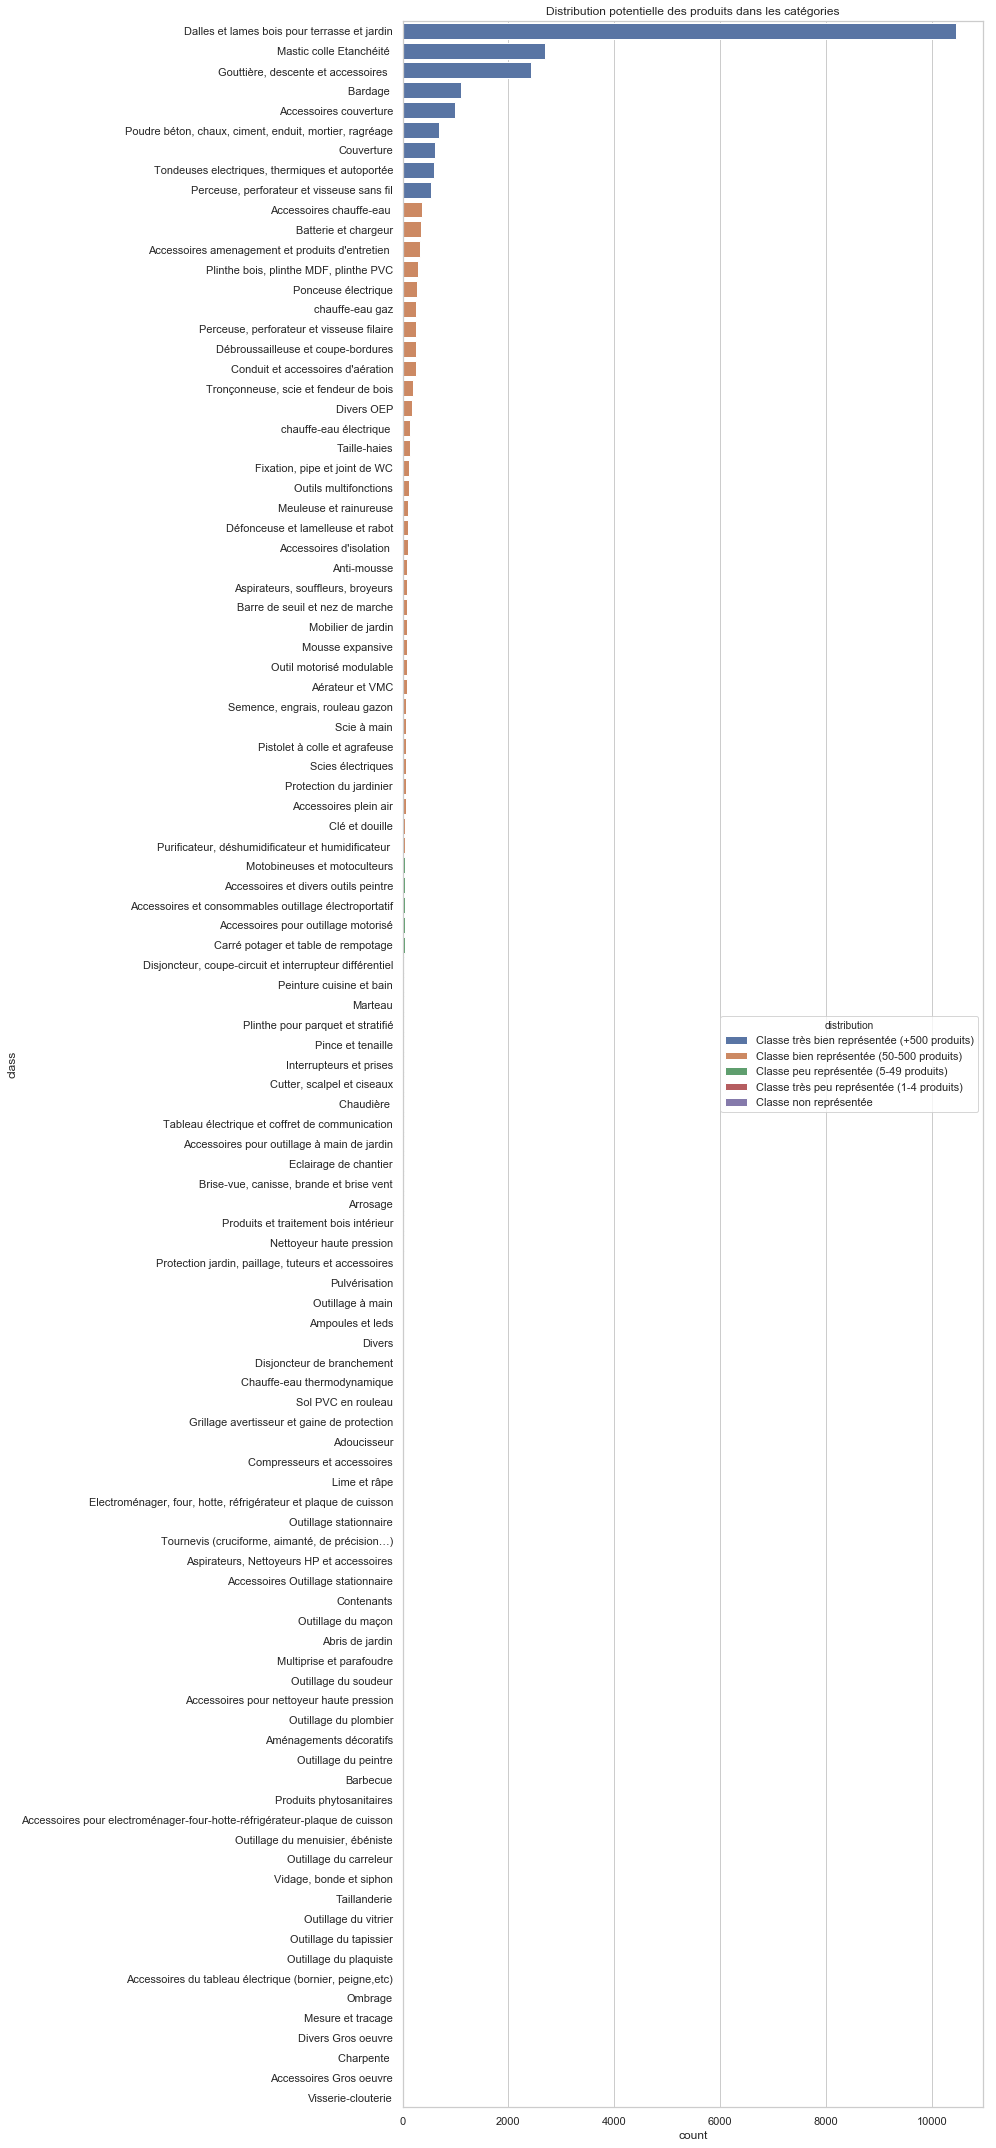

In [460]:
# Calcul de la fréquence des classes
predicted_classes = df_similarities_seuil['ref_product_family_best'].value_counts().index.tolist()
predicted_classes_count = df_similarities_seuil['ref_product_family_best'].value_counts().tolist()
classes = predicted_classes.copy()
classes_count = predicted_classes_count.copy()
for category in df_ref_product_family_translated.ref_product_family:
    if category not in predicted_classes:
        classes.append(category)
        classes_count.append(0)
dict_classes = {'class': classes, 'count': classes_count}
df_classes = pd.DataFrame(data=dict_classes).sort_values('count', ascending=False)

# Création d'une légende pour catégoriser les distributions des classes
distribution = []
i = 0
for index, category in enumerate(df_classes["class"], 0):
    if df_classes["count"][index]>500:
        distribution.append("Classe très bien représentée (+500 produits)")
    elif df_classes["count"][index]>=50:
        distribution.append("Classe bien représentée (50-500 produits)")
    elif df_classes["count"][index]>=5:
        distribution.append("Classe peu représentée (5-49 produits)")
    elif df_classes["count"][index]>0:
        distribution.append("Classe très peu représentée (1-4 produits)")
    else :
        distribution.append("Classe non représentée")
df_classes["distribution"] = distribution

# On affiche en barplot
plt.figure(figsize=(14,30))
sns.barplot(x="count",
            y="class",
#             data=df_classes.iloc[50:,:], # on zoome
            data=df_classes,
            hue="distribution", dodge=False)
plt.title("Distribution potentielle des produits dans les catégories")
plt.tight_layout()

In [461]:
sources_pie = go.Pie(labels=df_classes["distribution"].value_counts().index, values=df_classes["distribution"].value_counts(),
                     marker=dict(line=dict(color='#FFF', width=2)), showlegend=True,
                     name='Distribution potentielle des produits dans les catégories', textinfo='label+percent')

layout = go.Layout(height = 600,
                   width = 1000,
                   autosize = False,
                   title = 'Proportion de présence potentielle des produits dans les catégories')
fig = go.Figure(data = [sources_pie], layout = layout)

py.iplot(fig, filename='basic_pie_chart')

C:\Users\Pascal\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



On s'aperçoit qu'il y a environ 27% des catégories qui sont soit non représentées ou soit très peu représentées (<5).
Ca risque de poser des problèmes pour créer un modèle de classification supervisé car il y aura beaucoup de classes sous représentées.       
On est également embêté pour une classification semi-supervisé car toutes les classes ne sont pas représentés. On pourra potentiellement opté pour un zero shot semi-supervised learning.

### Analyse des résultats de similarité

Si on se concentre sur les catégories les plus représentées, on s'aperçoit que les trois premiers concentrent plus de 50% des données. On va s'intéresser plus en détails à ces données :

**Dalles et lames bois pour terrasse et jardin (Wooden slabs and slats for terrace and garden):**

In [462]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Dalles et lames bois pour terrasse et jardin'].product_family_translated.unique()

array(['Plastic greenhouses', 'Wooden terraces and fences',
       'Waterproofing of roof and terrace',
       'Waterproofing of roofs and terraces', 'Awning awning',
       'Accessory for shutters  windows and gates',
       "Trellis and trompe l'oeil", 'Flower box - balcony door', 'Tiles',
       'Balustrade and railing for terrace and garden',
       'Waterproofing of soils and terraces',
       'Waterproofing product for floors and terraces', 'Trellis',
       'Pergola', 'Terrace slab  grating', 'Waterproofing Terrace',
       'Terracotta tiles', 'Under-roof screens', 'Glass tiles'],
      dtype=object)

In [463]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Dalles et lames bois pour terrasse et jardin'].product_family.unique()

array(['Serres en plastique', 'Terrasses et barrières en bois',
       'Étanchéité toiture et terrasse',
       'Etanchéité des toitures et terrasses', 'Store banne',
       'Accessoire pour volet, fenêtre et portail',
       "Treillage et trompe l'œil", 'Jardinière - Balconnière', 'Tuiles',
       'Balustrade et garde-corps pour terrasse et jardin',
       'Etanchéité des sols et terrasses',
       "Produit d'étanchéité pour sol et terrasse", 'Treillage',
       'Pergola', 'Dalle terrasse, caillebotis', 'Etanchéité Terrasse',
       'Tuiles terre cuite', 'Ecrans sous-toiture', 'Tuiles de verre'],
      dtype=object)

On remarque qu'il y a beaucoup de produits qui sont mal classés malgré qu'on ait mis un seuil à 0.5. En effet le mot en anglais **terrace** revient dans les termes de la catégorie de référence et les mots **glass** et **tiles** sont très proche de **slabs** et **slats**.

In [464]:
print("Cosine glass-tiles/slabs-slats : ", model.n_similarity(['glass', 'tiles'], ['slats', 'slabs']))

Cosine glass-tiles/slabs-slats :  0.56271714


**Mastic colle Etanchéité (Adhesive sealant Sealing):**

In [465]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Mastic colle Etanchéité '].product_family_translated.unique()

array(['Tile adhesives', 'Sealing products', 'Latex putty',
       'Universal adhesives', 'Industrial adhesive tape', 'Waterproofing',
       'Coatings', 'Contact adhesives', 'Sealing treatment', 'Sealants',
       'Sealant cartridge and sealant', 'Sealing of the facade',
       'Insulation adhesive', 'Glue and adhesive', 'Soil sealing',
       'Adhesive', 'Wall sealing', 'Glues', 'Adhesive / Glue',
       'Adhesives  glues', 'Adhesives and sealants', 'Silicone glues',
       'Acrylic glues', 'Sealing strip', 'Polyurethane adhesives',
       'Epoxy resin', 'Glue and adhesive sealant', 'Sealing putty',
       'Sealing accessory', 'Fastening putty', 'Roofing sealant',
       'Sealing roller', 'Other sealing material', 'Epoxy glue',
       'Marine glue and sealant', 'Polishing cap and sponge',
       'Miscellaneous adhesive tape', 'Neutral silicone sealant',
       'Polyurethane putty', 'Bituminous coating', 'Acrylic putty',
       'Waterproofing and Swimming Pool Coating', 'Surface harde

In [466]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Mastic colle Etanchéité '].product_family.unique()

array(['Colles à carrelage', "Produits d'étanchéité", 'Mastic au latex',
       'Colles universelles', 'Ruban adhésif industriel',
       'Étanchéisation', 'Enduits', 'Colles de contact',
       'Traitement étanchéité', 'Mastics', 'Cartouche mastic et joint',
       'Etanchéité', 'Etanchéité de la façade', 'Colle pour isolant',
       'Colle et adhésif', 'Etanchéité du sol', 'Adhésif',
       'Etanchéité mur', 'Colles', 'Adhésif / Colle', 'Adhésifs, colles',
       'Colles mastic', 'Imperméabilisant', 'Colles Silicone',
       'Colles Acrylique', "Bande d'étanchéité", 'Colles polyuréthane',
       'Résine époxy', 'Colle et mastic colle', "Mastic d'étanchéité",
       "Accessoire d'étanchéité", 'Mastic de fixation',
       "Produit d'étanchéité pour toiture", "Rouleau d'étanchéité",
       "Autre produit d'étanchéité", 'Colle epoxy',
       'Colle et mastic de marine', 'Bonnet et éponge de polissage',
       'Ruban adhésif divers', 'Mastic silicone neutre',
       'Mastic polyuréthane',

La plupart des familles de produits correspondent bien à la référence sauf **Bonnet et éponge de polissage (Polishing cap and sponge)**.

**Gouttière, descente et accessoires (Gutter, downspout and accessories):**

In [467]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Gouttière, descente et accessoires  '].product_family_translated.unique()

array(['Rainwater drainage', 'Gutter and accessories',
       'Gutter  manhole  drain grate and siphon', 'PVC gutter',
       'Gutter  siphon and manhole', 'Gutter and downspout connection',
       'Gutter and downspout accessories', 'Gutter and downspout',
       'Gutter connection', 'Fastening element for gutter',
       'Gutter adapter', 'Gutter screw', 'PVC drainage connection',
       'Gutter accessory'], dtype=object)

In [468]:
df_similarities_seuil[df_similarities_seuil.ref_product_family_best=='Gouttière, descente et accessoires  '].product_family.unique()

array(['Evacuation des eaux de pluie', 'Gouttière et accessoire',
       "Caniveau, regard, grille d'évacuation et siphon", 'Gouttière PVC',
       'Caniveau, siphon et regard', 'Raccord de gouttière et descente',
       'Accessoires gouttière et descente', 'Gouttière et descente',
       'Raccord pour gouttière', 'Elément de fixation pour gouttière',
       'Adaptateur pour gouttière', 'Vis de gouttière',
       "Raccord PVC d'évacuation", 'Accessoire pour gouttière'],
      dtype=object)

La traduction a permis de faire apparaître **gutter** dans toutes ces catégories et qui se retrouvent dans la référence **Gutter, downspout and accessories**. Il y a ici un sans faute car le mot est présent dans la référence. La représentation Word2Vec a également réussi à rapprocher la catégorie **Rainwater drainage** à **Gutter, downspout and accessories**.